In [1]:
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt

In [2]:
def quant(x,c):
    return np.quantile(x,c,1)
def get_sub(r,d):
    return npl.svd(np.random.randn(r,d))[2][:r]
def randn_norm(T,r):
    X=np.random.randn(T,r)
    return np.array([X[i]/npl.norm(X[i]) for i in range(T)])

def eig_R(X,r):
    SH,V,_=npl.svd(X)
    return SH[:,:r].T,np.diag(V[:r])

def do_one_iter():
    T1 = K*k1; T2=K*k2; T=T1+T2
    # T=K*k1 + K*k2
    print(f'# of tasks {T}.')
    print(f'# of total samples {T1*n1+T2*n2}')
    ERR=10000*np.ones((2,3,3))
    SM=get_sub(R,d)
    SC=[]
    SCC=[]
    for i in range(2*K):
        SC.append(get_sub(r,R))
        SCC.append(SC[i].dot(SM))

    betas=randn_norm(T,r).reshape(K,k1+k2,r)
    betah=np.zeros((K,k1+k2,d))
    betasD=np.zeros((K,k1+k2,d))
    yy1=np.zeros((K,k1,n1))
    XX1=np.random.randn(K,k1,n1,d)
    yy2=np.zeros((K,k2,n2))
    XX2=np.random.randn(K,k2,n2,d)
    yt1=np.zeros((K,k1,n2+n2))
    XT1=np.random.randn(K,k1,n2+n2,d)
    yt2=np.zeros((K,k2,n2+n2))
    XT2=np.random.randn(K,k2,n2+n2,d)
    corr=np.zeros((K,k1+k2))
    for i in range(K):
        for j in range(k1):
            betasD[i,j]=SCC[i].T.dot(betas[i,j])
            yy1[i,j]=XX1[i,j].dot(betasD[i,j])+np.random.randn(n1) * np.sqrt(sigma)
            yt1[i,j]=XT1[i,j].dot(betasD[i,j])+np.random.randn(n2+n2) * np.sqrt(sigma)
            betah[i,j]=XX1[i,j].T.dot(yy1[i,j])/n1
            corr[i,j]=betah[i,j].dot(betasD[i,j])/npl.norm(betah[i,j])
        for j in range(k2):
            j_=j+k1
            betasD[i,j_]=SCC[i+K].T.dot(betas[i,j_])
            yy2[i,j]=XX2[i,j].dot(betasD[i,j_])+np.random.randn(n2) * np.sqrt(sigma)
            yt2[i,j]=XT2[i,j].dot(betasD[i,j_])+np.random.randn(n2+n2) * np.sqrt(sigma)
            betah[i,j_]=XX2[i,j].T.dot(yy2[i,j])/n2
            corr[i,j_]=betah[i,j_].dot(betasD[i,j_])/npl.norm(betah[i,j_])

    # Moment-based MTL, C-MTL, MP-MTL initializations
    MOM=np.zeros((d,d))
    MOMT=[]
    for i in range(K):
        MOMT.append(np.zeros((d,d)))
        for j in range(k1):
            MOM+=np.outer(betah[i,j],betah[i,j])
            MOMT[-1]+=np.outer(betah[i,j],betah[i,j])
        MOMT[-1]/=k1

        MOMT.append(np.zeros((d,d)))
        for j in range(k2):
            j_ = j+k1
            MOM+=np.outer(betah[i,j_],betah[i,j_])
            MOMT[-1]+=np.outer(betah[i,j_],betah[i,j_])
        MOMT[-1]/=k2
    MOM/=T

    HM,_=eig_R(MOM,R)
    HC=[]
    errsubT=0
    for i in range(2*K):
        MOMH,_=eig_R(MOMT[i],r)
        errsubT+=npl.norm(MOMH.T.dot(MOMH)-SCC[i].T.dot(SCC[i]),'fro')/npl.norm(SCC[i].T.dot(SCC[i]))
        HC.append(MOMH)

    MOMC=[]
    MOMCC=[]
    errsubP=0
    for i in range(2*K):
        MOMC.append(HM.T.dot(HM).dot(MOMT[i]).dot(HM.T.dot(HM)))

    HPC=[]
    for i in range(2*K):
        MOMH,_=eig_R(MOMC[i],r)
        errsubP+=npl.norm(MOMH.T.dot(MOMH)-SCC[i].T.dot(SCC[i]),'fro')/npl.norm(SC[i].T.dot(SC[i]))
        HPC.append(MOMH)

    HP=[]
    errsubPP=0
    for i in range(2*K):
        HP.append(HPC[i].dot(HM.T))
        MOMH=HP[i].dot(HM)
        errsubPP+=npl.norm(MOMH.T.dot(MOMH)-SCC[i].T.dot(SCC[i]),'fro')/npl.norm(SC[i].T.dot(SC[i]))

    # Alternating LS for MTL variations 
    GM=HM.copy()
    GT=np.array(HC)
    beta=np.zeros((K,k1+k2,d))
    betaC=np.zeros((K,k1+k2,r))

    ITN=10
    
    # MTL ALS
    for it in range(ITN):
        errM1=0
        errMT1=0
        errM2=0
        errMT2=0
        XC=np.zeros((n1*K*k1+n2*K*k2,R*d))
        yC=np.zeros((n1*K*k1+n2*K*k2))
        for i in range(K):
            for j in range(k1):
                X=XX1[i,j].dot(GM.T)
                beta[i,j]=GM.T.dot(npl.pinv(X).dot(yy1[i,j]))
                errM1+=npl.norm(yy1[i,j]-XX1[i,j].dot(beta[i,j]))**2/n1
                errMT1+=npl.norm(yt1[i,j]-XT1[i,j].dot(beta[i,j]))**2/(n1+n2)
                yC[n1*(i*k1+j):n1*(i*k1+j+1)]=yy1[i,j]
                XC[n1*(i*k1+j):n1*(i*k1+j+1)]=np.kron(GM.dot(beta[i,j]),XX1[i,j])
            for j in range(k2):
                j_ = j+k1
                temp = n1*K*k1
                X=XX2[i,j].dot(GM.T)
                beta[i,j_]=GM.T.dot(npl.pinv(X).dot(yy2[i,j]))
                errM2+=npl.norm(yy2[i,j]-XX2[i,j].dot(beta[i,j_]))**2/n2
                errMT2+=npl.norm(yt2[i,j]-XT2[i,j].dot(beta[i,j_]))**2/(n1+n2)
                yC[temp+n2*(i*k2+j):temp+n2*(i*k2+j+1)]=yy2[i,j]
                XC[temp+n2*(i*k2+j):temp+n2*(i*k2+j+1)]=np.kron(GM.dot(beta[i,j_]),XX2[i,j])
        GM=npl.pinv(XC).dot(yC).reshape(R,d)
        ERR[0,0,0]=np.minimum(ERR[0,0,0],errM1/T1)
        ERR[1,0,0]=np.minimum(ERR[1,0,0],errMT1/T1)
        ERR[0,0,1]=np.minimum(ERR[0,0,1],errM2/T2)
        ERR[1,0,1]=np.minimum(ERR[1,0,1],errMT2/T2)
        ERR[0,0,2]=np.minimum(ERR[0,0,2],(errM1+errM2)/T)
        ERR[1,0,2]=np.minimum(ERR[1,0,2],(errMT1+errMT2)/T)

    # C-MTL ALS
    for it in range(ITN):
        errT1=0
        errTT1=0
        errT2=0
        errTT2=0
        for i in range(K):
            XC=np.zeros((n1*k1,r*d))
            yC=np.zeros((n1*k1))
            for j in range(k1):
                X=XX1[i,j].dot(GT[i].T)
                betaC[i,j]=npl.pinv(X).dot(yy1[i,j])
                errT1+=npl.norm(yy1[i,j]-XX1[i,j].dot(GT[i].T.dot(betaC[i,j])))**2/n1
                errTT1+=npl.norm(yt1[i,j]-XT1[i,j].dot(GT[i].T.dot(betaC[i,j])))**2/(n1+n2)
            for j in range(k1):
                yC[n1*j:n1*(j+1)]=yy1[i,j]
                XC[n1*j:n1*(j+1)]=np.kron(betaC[i,j],XX1[i,j])
            GT[i]=npl.pinv(XC).dot(yC).reshape(r,d)
            XC=np.zeros((n2*k2,r*d))
            yC=np.zeros((n2*k2))
            i_ = i+K
            for j in range(k2):
                j_ = j+k1
                X=XX2[i,j].dot(GT[i_].T)
                betaC[i,j_]=npl.pinv(X).dot(yy2[i,j])
                errT2+=npl.norm(yy2[i,j]-XX2[i,j].dot(GT[i_].T.dot(betaC[i,j_])))**2/n2
                errTT2+=npl.norm(yt2[i,j]-XT2[i,j].dot(GT[i_].T.dot(betaC[i,j_])))**2/(n1+n2)
            for j in range(k2):
                j_ = j+k1
                yC[n2*j:n2*(j+1)]=yy2[i,j]
                XC[n2*j:n2*(j+1)]=np.kron(betaC[i,j_],XX2[i,j])
            GT[i_]=npl.pinv(XC).dot(yC).reshape(r,d)
        ERR[0,1,0]=np.minimum(ERR[0,1,0],errT1/T1)
        ERR[1,1,0]=np.minimum(ERR[1,1,0],errTT1/T1)
        ERR[0,1,1]=np.minimum(ERR[0,1,1],errT2/T2)
        ERR[1,1,1]=np.minimum(ERR[1,1,1],errTT2/T2)
        ERR[0,1,2]=np.minimum(ERR[0,1,2],(errT1+errT2)/T)
        ERR[1,1,2]=np.minimum(ERR[1,1,2],(errTT1+errTT2)/T)
    
    
    # MP-MTL ALS
    GP=np.array(HP)
    GPC=np.array(HPC)
    GPM=HM.copy()
    betaP=np.zeros((K,k1+k2,d))
    betaPC=np.zeros((K,k1+k2,r))
    for it in range(ITN):
        errP1=0
        errPT1=0
        errP2=0
        errPT2=0
        XM=np.zeros((n1*k1*K+n2*k2*K,R*d))
        yM=np.zeros((n1*k1*K+n2*k2*K))
        for i in range(K):
            GPC[i]=GP[i].dot(GPM)
            for j in range(k1):
                X=XX1[i,j].dot(GPC[i].T)
                betaPC[i,j]=npl.pinv(X).dot(yy1[i,j])
                errP1+=npl.norm(yy1[i,j]-XX1[i,j].dot(GPC[i].T.dot(betaPC[i,j])))**2/n1
                errPT1+=npl.norm(yt1[i,j]-XT1[i,j].dot(GPC[i].T.dot(betaPC[i,j])))**2/(n1+n2)
            XC=np.zeros((n1*k1,r*R))
            yC=np.zeros((n1*k1))
            for j in range(k1):
                yC[n1*j:n1*(j+1)]=yy1[i,j]
                XC[n1*j:n1*(j+1)]=np.kron(betaPC[i,j],XX1[i,j].dot(GPM.T))
            GP[i]=npl.pinv(XC).dot(yC).reshape(r,R)
            for j in range(k1):
                bth=GP[i].T.dot(betaPC[i,j])
                yM[n1*(i*k1+j):n1*(i*k1+j+1)]=yy1[i,j]
                XM[n1*(i*k1+j):n1*(i*k1+j+1)]=np.kron(bth,XX1[i,j])

            i_ = i+K
            GPC[i_]=GP[i_].dot(GPM)
            for j in range(k2):
                j_ = j+k1
                X=XX2[i,j].dot(GPC[i_].T)
                betaPC[i,j_]=npl.pinv(X).dot(yy2[i,j])
                errP2+=npl.norm(yy2[i,j]-XX2[i,j].dot(GPC[i_].T.dot(betaPC[i,j_])))**2/n2
                errPT2+=npl.norm(yt2[i,j]-XT2[i,j].dot(GPC[i_].T.dot(betaPC[i,j_])))**2/(n1+n2)
            XC=np.zeros((n2*k2,r*R))
            yC=np.zeros((n2*k2))
            for j in range(k2):
                j_ = j+k1
                yC[n2*j:n2*(j+1)]=yy2[i,j]
                XC[n2*j:n2*(j+1)]=np.kron(betaPC[i,j_],XX2[i,j].dot(GPM.T))
            GP[i_]=npl.pinv(XC).dot(yC).reshape(r,R)
            for j in range(k2):
                j_ = j+k1
                temp = n1*K*k1
                bth=GP[i_].T.dot(betaPC[i,j_])
                yM[temp+n2*(i*k2+j):temp+n2*(i*k2+j+1)]=yy2[i,j]
                XM[temp+n2*(i*k2+j):temp+n2*(i*k2+j+1)]=np.kron(bth,XX2[i,j])
        GPM=npl.pinv(XM).dot(yM).reshape(R,d)
        #print('Path Train',it,errP/T,'Test',errPT/T)
        ERR[0,2,0]=np.minimum(ERR[0,2,0],errP1/T1)
        ERR[1,2,0]=np.minimum(ERR[1,2,0],errPT1/T1)
        ERR[0,2,1]=np.minimum(ERR[0,2,1],errP2/T2)
        ERR[1,2,1]=np.minimum(ERR[1,2,1],errPT2/T2)
        ERR[0,2,2]=np.minimum(ERR[0,2,2],(errP1+errP2)/T)
        ERR[1,2,2]=np.minimum(ERR[1,2,2],(errPT1+errPT2)/T)
    return ERR

In [3]:
sigma = 0.02
ITN=1 # NUMBER OF AVERAGES TO RUN
r=2
R=4*r
d=4*R

n0=5
Kb=20
k1s = [2,4,7,10,15,20,30,40,50] 
LEN=len(k1s)
n1s = (np.arange(LEN)*4+1)*1

ERRn=np.zeros((LEN,ITN,2,3,3))
ERRk=np.zeros((LEN,ITN,2,3,3))

print('Vary # samples')
for x in range(LEN):
    n1=n1s[x]; n2=n1s[-1]; k1=10; k2=10; K=Kb//2
    print(n1,n2,k1,k2,K)
    for it in range(ITN):
        ERRn[x,it]=do_one_iter()

print('Vary # tasks')
for x in range(LEN):
    n1=10; n2=10; k1=k1s[x]; k2=k1s[-1]; K=Kb//2
    print(n1,n2,k1,k2,K)
    for it in range(ITN):
        ERRk[x,it]=do_one_iter()

# np.save('error_n1.npy',ERRn)
# np.save('error_k1.npy',ERRk)

Vary # samples
1 33 10 10 10
# of tasks 200.
# of total samples 3400
5 33 10 10 10
# of tasks 200.
# of total samples 3800
9 33 10 10 10
# of tasks 200.
# of total samples 4200
13 33 10 10 10
# of tasks 200.
# of total samples 4600
17 33 10 10 10
# of tasks 200.
# of total samples 5000
21 33 10 10 10
# of tasks 200.
# of total samples 5400
25 33 10 10 10
# of tasks 200.
# of total samples 5800
29 33 10 10 10
# of tasks 200.
# of total samples 6200
33 33 10 10 10
# of tasks 200.
# of total samples 6600
Vary # tasks
10 10 2 50 10
# of tasks 520.
# of total samples 5200
10 10 4 50 10
# of tasks 540.
# of total samples 5400
10 10 7 50 10
# of tasks 570.
# of total samples 5700
10 10 10 50 10
# of tasks 600.
# of total samples 6000
10 10 15 50 10
# of tasks 650.
# of total samples 6500
10 10 20 50 10
# of tasks 700.
# of total samples 7000
10 10 30 50 10
# of tasks 800.
# of total samples 8000
10 10 40 50 10
# of tasks 900.
# of total samples 9000
10 10 50 50 10
# of tasks 1000.
# of total 

In [4]:
# ERRn=np.load('error_vary_n_v2.npy')
# ERRk=np.load('error_vary_k_v2.npy')

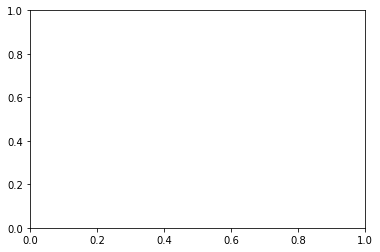

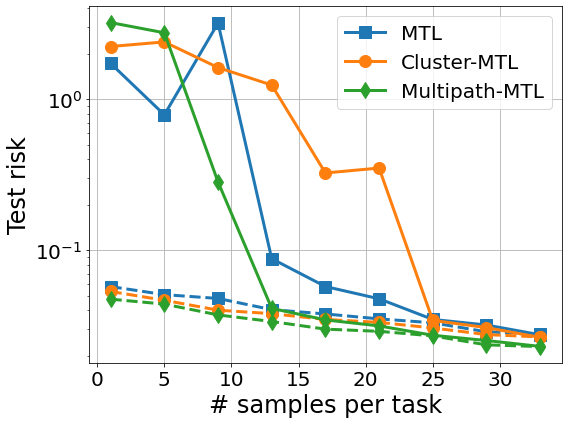

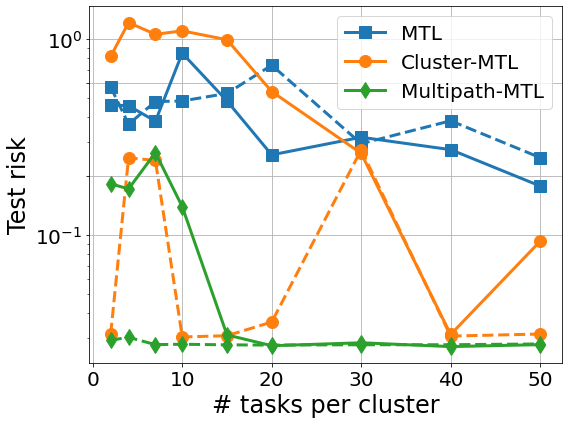

In [5]:
idx = 0
mrk=['s','o','d']
labels=['MTL','Cluster-MTL','Multipath-MTL']
ax = plt.gca()
plt.figure(figsize=(8,6))
for i in range(3):
    color = next(ax._get_lines.prop_cycler)['color']
    plt.semilogy(n1s,quant(ERRn[:,:,1,i,idx],0.5),'-'+mrk[i],color=color,linewidth=3,markersize=12,label=labels[i])
    plt.semilogy(n1s,quant(ERRn[:,:,1,i,idx+1],0.5),'--'+mrk[i],color=color,linewidth=3,markersize=12)
    plt.fill_between(n1s,quant(ERRn[:,:,1,i,idx],0.25),quant(ERRn[:,:,1,i,idx],0.75),alpha=0.25)
# plt.ylim([0.02,1])
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('# samples per task',fontsize=24)
plt.ylabel('Test risk',fontsize=24)
plt.grid(True)
plt.tight_layout()
# plt.savefig('worse_sample_per_task.pdf')
ax = plt.gca()
plt.figure(figsize=(8,6))
for i in range(3):
    color = next(ax._get_lines.prop_cycler)['color']
    plt.semilogy(k1s,quant(ERRk[:,:,1,i,idx],0.5),'-'+mrk[i],color=color,linewidth=3,markersize=12, label=labels[i])
    plt.fill_between(k1s,quant(ERRk[:,:,1,i,idx],0.25),quant(ERRk[:,:,1,i,idx],0.75),alpha=0.25)
    if i==10:
        plt.semilogy(k1s,[np.mean(quant(ERRk[:,:,1,i,idx+1],0.5))]*LEN,'--'+mrk[i],color=color,linewidth=3,markersize=12)
    else:
        plt.semilogy(k1s,quant(ERRk[:,:,1,i,idx+1],0.5),'--'+mrk[i],color=color,linewidth=3,markersize=12)
# plt.ylim([0.02,1])
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks([0.1,0.2,0.6,1],fontsize=20)
plt.xlabel('# tasks per cluster',fontsize=24)
plt.ylabel('Test risk',fontsize=24)
plt.grid(True)
plt.tight_layout()
# plt.savefig('worse_task_per_cluster.pdf')
